Group Name: AG 19

Student Name (Student ID):

1. Lee Han Jian (A0248322J)

2. LI SHENGDONG (A0248417Y)

3. ZHENG WENGRUI (A0250948W)

# Assignment 3 - Reinforcement Learning

## GridWorlds

This assignment involves finding optimal policies for two grid worlds (CliffWalking and WindyGridWorld) using SARSA and Q learning. Details about WindyGridWorld (Example 6.5) and CliffWalking (Example 6.6) can be found in the following link.
    
    http://incompleteideas.net/book/RLbook2020.pdf


You need gym (version 0.18) and numpy (version 1.20.1) for this assignment. The environment for both problems are provided. 

For Windy Grid World environemnt you also need the file 'WindyGridWorld.py'. 

### Task 1: Learning [5 Marks]

You only need to write the codes for SARSA and Q-learning algorithms. Then do the learning in both 'CliffWalking' and 'Windy Grid World' environments. 

### Task 2: Analysis [5 Marks]   

1. Calculate the average return across the episodes. It gives you a measure of the performance of the algorithm while learning.  

2. Calculate the return after convergence. It gives you a measure of the performance after the learning is completed. 

3. What do you observe from these results?

Install the necessary packages

In [1]:
!pip install gym==0.18
!pip install numpy==1.20.1
!pip install tqdm 

# Task 1: Learning
## Task 1a: Learning in CliffWalking Environment

### Environment for CliffWalking

The board is a 4x12 matrix, with (using NumPy matrix indexing):
    [3, 0] as the start at bottom-left
    [3, 11] as the goal at bottom-right
    [3, 1..10] as the cliff at bottom-center

Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
and a reset to the start. If an action would take you off the grid, you remain in the previous state.
An episode terminates when the agent reaches the goal.


In [2]:

import gym
import numpy as np
from tqdm import tqdm 

env = gym.make('CliffWalking-v0') # Create the environment #render_mode="human"  human, ansi, 
env.reset() # reset environment to a new, random state
env.render() # Renders the environment for visualization

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



Here _x_ is the location of the agent, *o* are possible places to go to, *C* is the cliff, and *T* is the target.

In [3]:
num_actions = env.action_space.n 
num_states = env.observation_space.n 

print("Number of actions: ", num_actions)
print("Number of states: ", num_states)

Number of actions:  4
Number of states:  48


In [4]:
action = 0 # Move up
a = env.step(action) # This is the function we use to interact with the environment
env.render() # Renders the environment for visualization

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [5]:
# 0 -> UP, 1 -> RIGHT, 2 -> DOWN, 3 -> LEFT
env.reset()
import time
for action in [0, 1, 2, 3]:
    print("Action: ", action)
    time.sleep(1)
    next_state, reward, is_done, info = env.step(action)     # next_state, reward, is_done, info
    print("Next state: ", next_state)
    print("Reward: ", reward)
    print("Done: ",is_done)
    env.render()
env.reset()

Action:  0
Next state:  24
Reward:  -1
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action:  1
Next state:  25
Reward:  -1
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action:  2
Next state:  36
Reward:  -100
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action:  3
Next state:  36
Reward:  -1
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



36

As you can see above, each non-terminal action has a reward of -1. 0 -> UP, 1 -> RIGHT, 2 -> DOWN, 3 -> LEFT. The moment the agent falls off the cliff the reward becomes -100 and the agent resets to the start.

In [6]:
# Initialize values 
num_episodes = 500

# initialize learning rate alpha as 0.5 and epsilon as 0.1
# Actually we don't really use this lr, but we use a learning rate decay algorithm, 
# see "Explanation on Learning Rate Decaying algorithm we use" section below
lr = 0.5
epsilon = 0.1

# As in RLbook2020, we treat this problem as an undiscounted episodic task
# i.e. gamma = 1
gamma = 1

In [7]:
# Initialize Q function - a simplified version is used here 
# in reality the number of states may be unknown and all states may not be reachable 

# hint: use num_states as the key to a dictionary of lists

# initialize Q(s,a) = 0 for all s,a.
# The final structure of Q looks like:
# Q = {0: [0, 0, 0, 0], 1: [0, 0, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0], 4: [0, 0, 0, 0], 5: [0, 0, 0, 0], 6: [0, 0, 0, 0], 
#  7: [0, 0, 0, 0], 8: [0, 0, 0, 0], 9: [0, 0, 0, 0], 10: [0, 0, 0, 0], 11: [0, 0, 0, 0], 12: [0, 0, 0, 0], 13: [0, 0, 0, 0], 
#  14: [0, 0, 0, 0], 15: [0, 0, 0, 0], 16: [0, 0, 0, 0], 17: [0, 0, 0, 0], 18: [0, 0, 0, 0], 19: [0, 0, 0, 0], 20: [0, 0, 0, 0],
#  21: [0, 0, 0, 0], 22: [0, 0, 0, 0], 23: [0, 0, 0, 0], 24: [0, 0, 0, 0], 25: [0, 0, 0, 0], 26: [0, 0, 0, 0], 27: [0, 0, 0, 0],
#  28: [0, 0, 0, 0], 29: [0, 0, 0, 0], 30: [0, 0, 0, 0], 31: [0, 0, 0, 0], 32: [0, 0, 0, 0], 33: [0, 0, 0, 0], 34: [0, 0, 0, 0],
#  35: [0, 0, 0, 0], 36: [0, 0, 0, 0], 37: [0, 0, 0, 0], 38: [0, 0, 0, 0], 39: [0, 0, 0, 0], 40: [0, 0, 0, 0], 41: [0, 0, 0, 0],
#  42: [0, 0, 0, 0], 43: [0, 0, 0, 0], 44: [0, 0, 0, 0], 45: [0, 0, 0, 0], 46: [0, 0, 0, 0], 47: [0, 0, 0, 0]}
Q = {i: [0] * num_actions for i in range(num_states)}

In [8]:
def behavioral_policy(state, Q, num_actions, epsilon):
    # Implement the epsilon-greedy policy
    # Don't forget the epsilon-greedy idea
    
    # prob[best_action] = 1 - epsilon + epsilon/num_actions, prob[non-greedy_action] = epsilon/num_actions
    probs = np.full(num_actions, epsilon / num_actions)
    best_action = np.argmax(Q[state])
    probs[best_action] += 1 - epsilon
    
    action = np.argmax(np.random.multinomial(1, probs, size=1)[0])
    return action


# result = {i: 0 for i in range(4)}
# for i in range(100): 
#     action = behavioral_policy(0, {0: [1,0,2,0]}, 4, 0.8)
#     result[action] += 1
# print(result)


In [9]:
# You can use this to check if your algorithm is correct
for i in range(10):
    print(behavioral_policy(0, Q, num_actions, 0.8))

0
1
1
0
3
3
0
0
3
0


### SARSA Learning 

In [10]:
def sarsa(env, Q, num_actions, num_episodes, epsilon, lr):
    # Given to students
    episode_length = [0] * num_episodes
    total_reward_episode = [0] * num_episodes
    
    # visited 
    visited = {i: [0] * num_actions for i in range(num_states)}

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        # Implement SARSA
        
        action = behavioral_policy(state, Q, num_actions, epsilon)
        while not is_done:
            # take action in state
            next_state, reward, is_done, _ = env.step(action)
            # get next_action for next_state using behavioral policy
            next_action = behavioral_policy(next_state, Q, num_actions, epsilon)
            # calculate TD error
            target = reward + gamma * Q[next_state][next_action]
            predict = Q[state][action]
            error = target - predict
            
            # make learning rate decrease with time
            visited[state][action] += 1
            # alpha_n = 1 / (n ^ 0.51)
            lr = 1 / (visited[state][action] ** 0.51)
            
            # update Q[state][action]
            Q[state][action] = Q[state][action] + lr * error
            # update state as next_state, update action as next_action
            state = next_state
            action = next_action
            
            episode_length[episode] += 1
            total_reward_episode[episode] += reward
    policy = {}
    # Write code here as well
    # Hint: use np.argmax
    
    # calculate final found policy for each state 
    for s in Q:
        policy[s] = np.argmax(Q[s])

    return Q, policy, {"rewards": total_reward_episode, "length": episode_length}

In [11]:
# Run SARSA

# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}

optimal_sarsa_Q, sarsa_optimal_policy, sarsa_info = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)
print("\nGridWorld SARSA Optimal policy: \n", sarsa_optimal_policy)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1991.48it/s]


GridWorld SARSA Optimal policy: 
 {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 0, 13: 0, 14: 0, 15: 1, 16: 1, 17: 1, 18: 0, 19: 0, 20: 0, 21: 1, 22: 1, 23: 2, 24: 0, 25: 0, 26: 1, 27: 1, 28: 0, 29: 0, 30: 0, 31: 0, 32: 3, 33: 1, 34: 1, 35: 2, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}


### Q-Learning

In [12]:
def q_learning(env, Q, num_actions, num_episodes, epsilon, lr):
    # Given to students
    episode_length = [0] * num_episodes
    total_reward_episode = [0] * num_episodes
    
    # visited 
    visited = {i: [0] * num_actions for i in range(num_states)}


    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        # Implemnt Q-Learning
        
        while not is_done:
            # Choose action from state using behavioral policy 
            action = behavioral_policy(state, Q, num_actions, epsilon)
            # take action in state
            next_state, reward, is_done, _ = env.step(action)
            # calculate TD error
            target = reward + gamma * max(Q[next_state])
            predict = Q[state][action]
            error = target - predict
            
            # make learning rate decrease with time
            visited[state][action] += 1
            # alpha_n = 1 / (n ^ 0.51)
            lr = 1 / (visited[state][action] ** 0.51)
            
            # update Q[state][action]
            Q[state][action] = Q[state][action] + lr * error
            # update state as next_state
            state = next_state

            total_reward_episode[episode] += reward
            episode_length[episode] += 1
            
    policy = {}
    # Write the code here
    
    # calculate final found policy for each state 
    for s in Q:
        policy[s] = np.argmax(Q[s])

    return Q, policy, {"rewards": total_reward_episode, "length": episode_length}

In [13]:
# Run Q-Learning 

# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}

optimal_Q, q_optimal_policy, q_info = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)
print("\nGridWorld Q-Learning Optimal policy: \n", q_optimal_policy)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1878.51it/s]


GridWorld Q-Learning Optimal policy: 
 {0: 2, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 3, 7: 1, 8: 1, 9: 2, 10: 2, 11: 2, 12: 0, 13: 1, 14: 0, 15: 2, 16: 1, 17: 1, 18: 1, 19: 1, 20: 2, 21: 1, 22: 1, 23: 2, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 2, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}


In [14]:
# run this cell if you do not have the matplotlib library
# !pip install matplotlib
import matplotlib.pyplot as plt

In [15]:
def plot_rate(episode_length, total_reward_episode, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(episode_length)
    ax[0].set_title("Episode Length over time")
    ax[0].set(xlabel="Episode", ylabel="Length")
    ax[1].plot(total_reward_episode)
    ax[1].set_title("Episode reward over time")
    ax[1].set(xlabel="Episode reward over time", ylabel="Reward")
    fig.suptitle(title)

    plt.show()

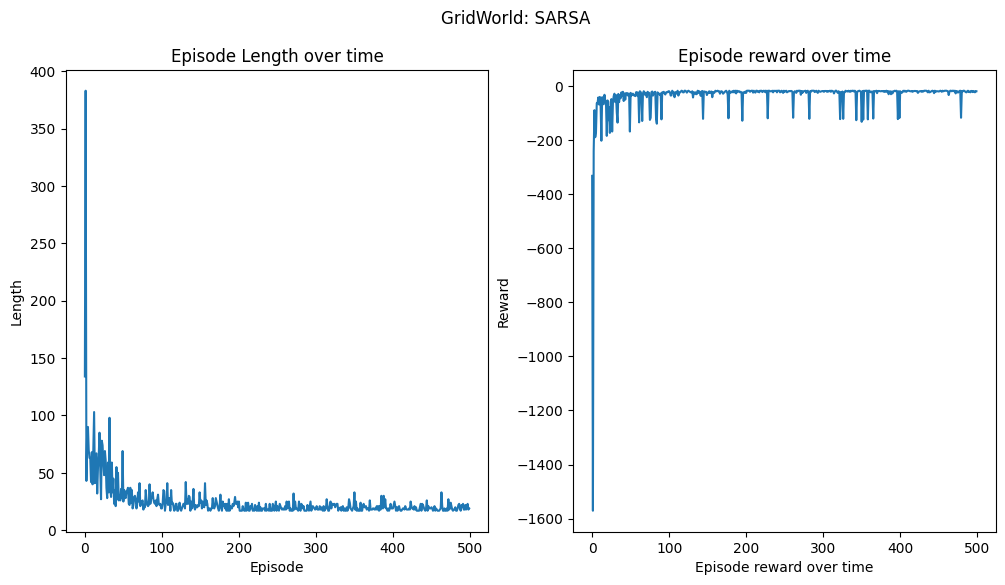

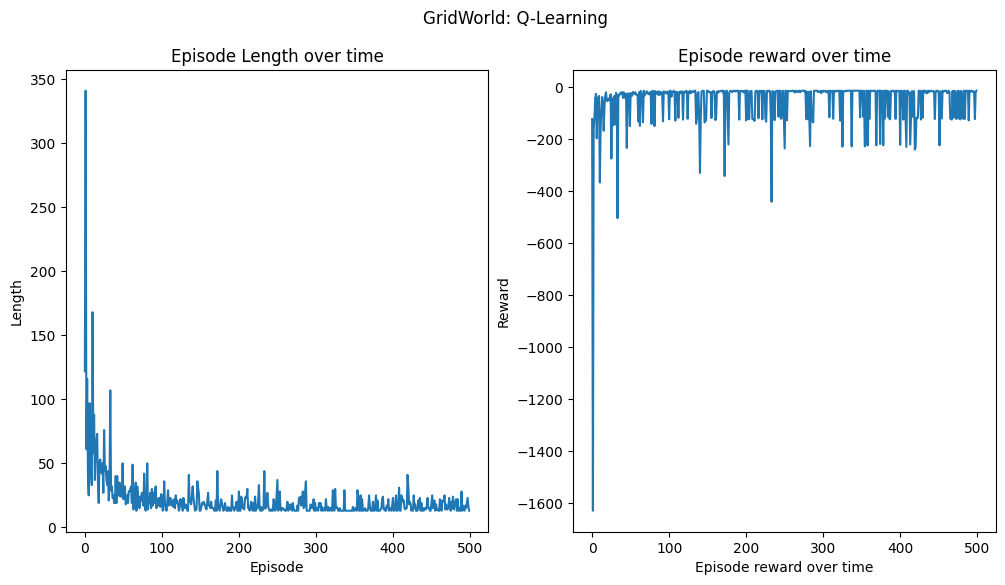

In [16]:
plot_rate(sarsa_info["length"], sarsa_info["rewards"], "GridWorld: SARSA")
plot_rate(q_info["length"], q_info["rewards"], "GridWorld: Q-Learning")

# smooth the curve drawn
# from scipy.signal import savgol_filter
# plot_rate(savgol_filter(sarsa_info["length"],51,3), savgol_filter(sarsa_info["rewards"],51,3), "GridWorld: SARSA (smoothed)")
# plot_rate(savgol_filter(q_info["length"],51,3), savgol_filter(q_info["rewards"],51,3), "GridWorld: Q-Learning (smoothed)")

## Task 1b: Learning in Windy Grid world

WindyGridWorld is similar to GridWorld, but with a few differences. You only need to move to the target state. But this time there is a cross-wind across the center of the grid that will push you upwards. In columns 3, 4, 5, and 8 there are winds of strength 1 while in column 6 and 7 there are winds of strength 2. For more details refer Example 6.5 in

 http://incompleteideas.net/book/RLbook2020.pdf

 You only need to change the environment and reuse the SARSA and Q-learning algorithms. 

In [17]:
#Windy Grid World environment
from WindyGridWorld import WindyGridWorld
env = WindyGridWorld()
env.reset()
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [18]:
num_actions = env.action_space.n 
num_states = env.observation_space.n 

print("Number of actions: ", num_actions)
print("Number of states: ", num_states)

Number of actions:  4
Number of states:  70


Play around with different learning rates epsilons, and Q initializations to see what is best.

In [19]:
num_episodes = 1000
# Actually we don't really use this lr, but we use a learning rate decay algorithm, 
# see "Explanation on Learning Rate Decaying algorithm we use" section below
lr = 0.5
epsilon = 0.1 

In [20]:
# Initialize Q function - a simplified version is used here 
# in reality the number of states may be unknown and all states may not be reachable 

# hint: use num_states as the key to a dictionary of lists

# initialize Q(s,a) as 0 for all s,a
Q = {i: [0] * num_actions for i in range(num_states)}

In [21]:
# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}

optimal_sarsa_Q, sarsa_optimal_policy, sarsa_info = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)
print("\n WindyGridWorld SARSA Optimal policy: \n", sarsa_optimal_policy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1516.39it/s]


 WindyGridWorld SARSA Optimal policy: 
 {0: 3, 1: 0, 2: 1, 3: 3, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 2, 11: 1, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 2, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 2, 28: 1, 29: 2, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1, 39: 2, 40: 2, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 2, 48: 3, 49: 3, 50: 1, 51: 0, 52: 1, 53: 1, 54: 1, 55: 0, 56: 0, 57: 2, 58: 3, 59: 2, 60: 2, 61: 0, 62: 1, 63: 1, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 3}


In [22]:
# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}

optimal_Q, q_optimal_policy, q_info = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)
print("\n WindyGridWorld Q-Learning Optimal policy: \n", q_optimal_policy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1899.03it/s]


 WindyGridWorld Q-Learning Optimal policy: 
 {0: 0, 1: 2, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 3, 11: 3, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 2, 20: 1, 21: 0, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 3, 28: 1, 29: 2, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1, 39: 2, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 2, 48: 3, 49: 3, 50: 2, 51: 2, 52: 1, 53: 1, 54: 1, 55: 0, 56: 0, 57: 2, 58: 3, 59: 3, 60: 1, 61: 1, 62: 1, 63: 1, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 3}


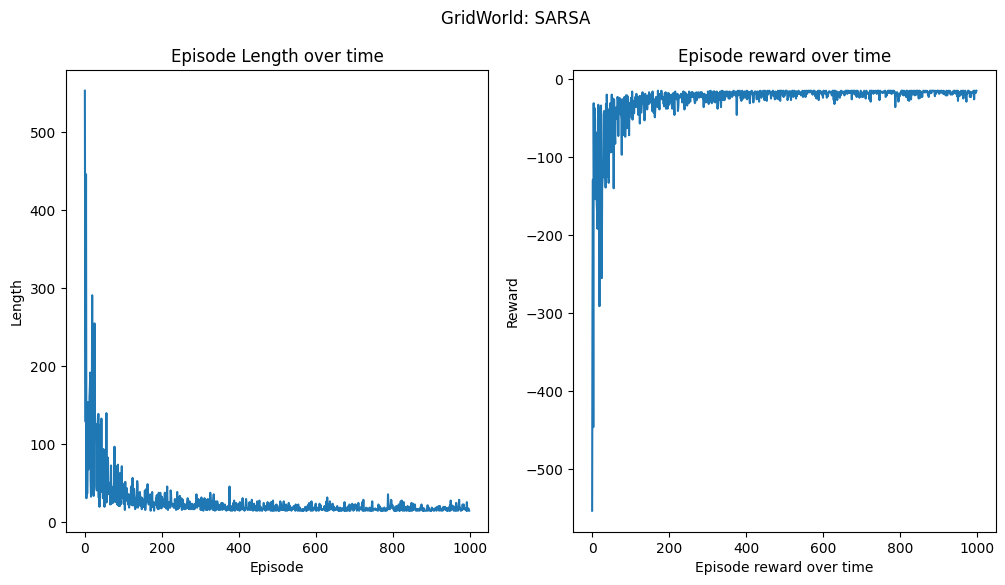

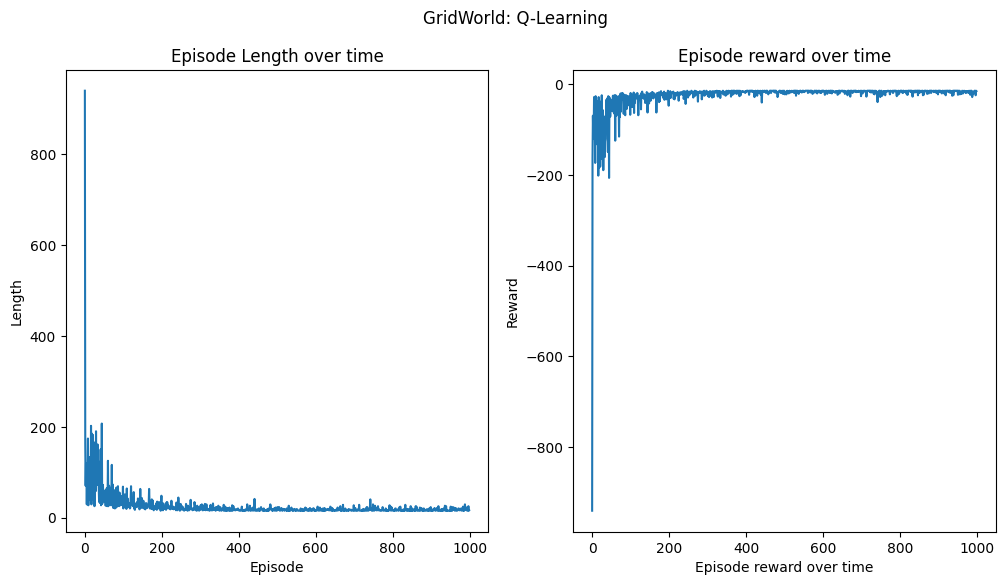

In [23]:
plot_rate(sarsa_info["length"], sarsa_info["rewards"], "GridWorld: SARSA")
plot_rate(q_info["length"], q_info["rewards"], "GridWorld: Q-Learning")

# smooth the curve drawn
# from scipy.signal import savgol_filter
# plot_rate(savgol_filter(sarsa_info["length"],51,3), savgol_filter(sarsa_info["rewards"],51,3), "GridWorld: SARSA (smoothed)")
# plot_rate(savgol_filter(q_info["length"],51,3), savgol_filter(q_info["rewards"],51,3), "GridWorld: Q-Learning (smoothed)")

### Explanation on Learning Rate Decaying algorithm we use

We choose to decrease the learning rate (`lr`) with time. That is to say, the more we have sampled one certain (state, action) pair, the less learning rate will a new sample of this (state, action) pair hold.

In order to make the TD methods converge, we have to meet the Robbins-Monro Conditions for Convergence:
$\Sigma_{n=1}^\infty \alpha_n = \infty$, $\Sigma_{n=1}^\infty \alpha_n^2 < \infty$

If we use p-series for $\alpha_n$, i.e. $\alpha_n = \frac 1 {n^p}$, then from the knowledge of series, we could easily know that
- To meet $\Sigma_{n=1}^\infty \alpha_n = \Sigma_{n=1}^\infty \frac 1 {n^p} = \infty$, we must have $p \leq 1$
- To meet $\Sigma_{n=1}^\infty \alpha_n^2 = \Sigma_{n=1}^\infty \frac 1 {n^{2p}} < \infty$, we must have $2p > 1$, i.e. $p > \frac12$

In conclusion, if $\frac12 < p \leq 1$, then $\alpha_n = \frac 1 {n^p}$ will meet the Robbins-Monro Conditions for Convergence.

In fact, $\alpha_n = \frac 1n$ is what we called sample-average case. The reasons why we use $p = 0.51$ instead of $p = 1$ is because in the Windy Grid world environment sample-average learning rate decaying will lead to bad performance.

Just take Q-learning as an example, see below return results. It fluctuates heavily even in the late learning phase.

One reason why $p = 1$ performs so unstable in this settings may be because the learning rate decays too faster before the algorithm reaches the stable phase. The faster decay in learning rate makes it harder for latter samples to quickly stablize the policy. It may need more samples to finally stablize its policy. However, due to the floating number precision constraints in computer system, after a certain threshold, the `lr` will be round to 0 instead of its true small value in mathematics which means the samples afterwards is totally useless. This means in real world $p = 1$ may not actually meet the Robbins-Monro Conditions due to precision constraints.

To circumvent this problem, we decide to make the decay of learning rate somewhat slower.

So we reduce the $p$ to 0.51, thus letting $\alpha_n = \frac 1{n^p}$ larger for the same n, which adds more weights to the latter samples of the same (state, action) pair. And the results turn out to be better as we could see above.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 428.11it/s]


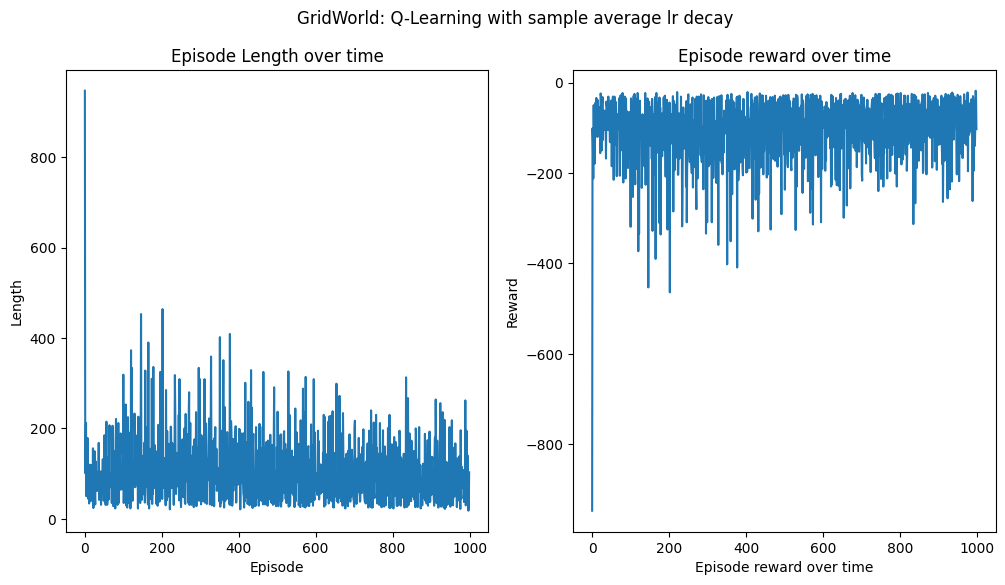

In [24]:
def q_learning_sample_average_lr_decay(env, Q, num_actions, num_episodes, epsilon, lr):
    # Given to students
    episode_length = [0] * num_episodes
    total_reward_episode = [0] * num_episodes
    
    # visited 
    visited = {i: [0] * num_actions for i in range(num_states)}


    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        # Implemnt Q-Learning
        
        while not is_done:
            # Choose action from state using behavioral policy 
            action = behavioral_policy(state, Q, num_actions, epsilon)
            # take action in state
            next_state, reward, is_done, _ = env.step(action)
            # calculate TD error
            target = reward + gamma * max(Q[next_state])
            predict = Q[state][action]
            error = target - predict
            
            # make learning rate decrease with time
            visited[state][action] += 1
            # alpha_n = 1 / (n ^ 0.51)
            lr = 1 / (visited[state][action])
            
            # update Q[state][action]
            Q[state][action] = Q[state][action] + lr * error
            # update state as next_state
            state = next_state

            total_reward_episode[episode] += reward
            episode_length[episode] += 1
            
    policy = {}
    # Write the code here
    
    # calculate final found policy for each state 
    for s in Q:
        policy[s] = np.argmax(Q[s])

    return Q, policy, {"rewards": total_reward_episode, "length": episode_length}


# Windy Grid World
from WindyGridWorld import WindyGridWorld
env = WindyGridWorld()
env.reset()

num_actions = env.action_space.n 
num_states = env.observation_space.n 
num_episodes = 1000
lr = 0.5
epsilon = 0.1 
gamma = 1

# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}

_, _, q_info_sample_average_lr_decay = q_learning_sample_average_lr_decay(env, Q, num_actions, num_episodes, epsilon, lr)

plot_rate(q_info_sample_average_lr_decay["length"], q_info_sample_average_lr_decay["rewards"], "GridWorld: Q-Learning with sample average lr decay")

### Different $\epsilon$ and initial Q

In this section, we try different $\epsilon$ and initial Q value to see which $\epsilon$ and initial Q value can produce better result.

Similar to RLbook2020 Figure 6.3, we measure Asymptotic Performance and Interim Performance to represent the learning perfomance in different learning rate and epsilon settings.

- For Asymptotic Performance, we use average of 1000 episodes
- For Interim Performance, we use average of first 100 episodes

#### The influence of $\epsilon$

Firstly, we try different $\epsilon$ value from 0.1 to 0.6 to see which $\epsilon$ value perform better in Windy Grid World environment for both SARSA and Q-learning.

In [25]:
# Windy Grid World
from WindyGridWorld import WindyGridWorld
env = WindyGridWorld()
env.reset()

num_actions = env.action_space.n 
num_states = env.observation_space.n 
num_episodes = 1000
lr = 0.5
gamma = 1

# initialize performance vector for different epsilon and TD methods
interim_performance = {"SARSA": [0] * 6, "Q": [0] * 6}
asymptotic_performance = {"SARSA": [0] * 6, "Q": [0] * 6}


for i in range(6):
    # epsilon = 0.1, 0.2, 0.3, ... 0.6
    epsilon = 0.1 * (i + 1)
    # SARSA learning
    # reset Q(s,a) as all zero before start learning
    Q = {i: [0] * num_actions for i in range(num_states)}
    
    optimal_sarsa_Q, sarsa_optimal_policy, sarsa_info = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)
    #print("\n WindyGridWorld SARSA Optimal policy: \n", sarsa_optimal_policy)
    average_total_rewards_asymptotic = sum(sarsa_info["rewards"])/len(sarsa_info["rewards"])
    average_total_rewards_interim = sum(sarsa_info["rewards"][:100])/len(sarsa_info["rewards"][:100])

    print(f"Asymptotic performance of SARSA learning with learning rate {lr:.1f} and epsilon {epsilon:.1f} is: " , average_total_rewards_asymptotic)
    print(f"Interim performance of SARSA learning with learning rate {lr:.1f} and epsilon {epsilon:.1f} is: " , average_total_rewards_interim)
    asymptotic_performance["SARSA"][i] = average_total_rewards_asymptotic
    interim_performance["SARSA"][i] = average_total_rewards_interim

    # Q learning
    # reset Q(s,a) as all zero before start learning
    Q = {i: [0] * num_actions for i in range(num_states)}
    
    optimal_Q, q_optimal_policy, q_info = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)
    #print("\n WindyGridWorld Q-Learning Optimal policy: \n", q_optimal_policy)
    average_total_rewards_asymptotic = sum(q_info["rewards"])/len(q_info["rewards"])
    average_total_rewards_interim = sum(q_info["rewards"][:100])/len(q_info["rewards"][:100])

    print(f"Asymptotic performance of Q learning with learning rate {lr:.1f} and epsilon {epsilon:.1f} is: " , average_total_rewards_asymptotic)
    print(f"Interim performance of Q learning with learning rate {lr:.1f} and epsilon {epsilon:.1f} is: " , average_total_rewards_interim)
    asymptotic_performance["Q"][i] = average_total_rewards_asymptotic
    interim_performance["Q"][i] = average_total_rewards_interim

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2023.65it/s]


Asymptotic performance of SARSA learning with learning rate 0.5 and epsilon 0.1 is:  -26.805
Interim performance of SARSA learning with learning rate 0.5 and epsilon 0.1 is:  -89.53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1792.07it/s]


Asymptotic performance of Q learning with learning rate 0.5 and epsilon 0.1 is:  -25.11
Interim performance of Q learning with learning rate 0.5 and epsilon 0.1 is:  -78.29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1616.50it/s]


Asymptotic performance of SARSA learning with learning rate 0.5 and epsilon 0.2 is:  -30.752
Interim performance of SARSA learning with learning rate 0.5 and epsilon 0.2 is:  -87.91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1926.79it/s]


Asymptotic performance of Q learning with learning rate 0.5 and epsilon 0.2 is:  -27.965
Interim performance of Q learning with learning rate 0.5 and epsilon 0.2 is:  -82.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1107.27it/s]


Asymptotic performance of SARSA learning with learning rate 0.5 and epsilon 0.3 is:  -39.24
Interim performance of SARSA learning with learning rate 0.5 and epsilon 0.3 is:  -115.88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1364.08it/s]


Asymptotic performance of Q learning with learning rate 0.5 and epsilon 0.3 is:  -31.928
Interim performance of Q learning with learning rate 0.5 and epsilon 0.3 is:  -90.92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 997.99it/s]


Asymptotic performance of SARSA learning with learning rate 0.5 and epsilon 0.4 is:  -47.648
Interim performance of SARSA learning with learning rate 0.5 and epsilon 0.4 is:  -116.13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1046.89it/s]


Asymptotic performance of Q learning with learning rate 0.5 and epsilon 0.4 is:  -38.047
Interim performance of Q learning with learning rate 0.5 and epsilon 0.4 is:  -99.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 655.03it/s]


Asymptotic performance of SARSA learning with learning rate 0.5 and epsilon 0.5 is:  -62.398
Interim performance of SARSA learning with learning rate 0.5 and epsilon 0.5 is:  -146.16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1008.74it/s]


Asymptotic performance of Q learning with learning rate 0.5 and epsilon 0.5 is:  -47.163
Interim performance of Q learning with learning rate 0.5 and epsilon 0.5 is:  -116.9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 471.21it/s]


Asymptotic performance of SARSA learning with learning rate 0.5 and epsilon 0.6 is:  -94.863
Interim performance of SARSA learning with learning rate 0.5 and epsilon 0.6 is:  -209.72


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 722.43it/s]

Asymptotic performance of Q learning with learning rate 0.5 and epsilon 0.6 is:  -64.64
Interim performance of Q learning with learning rate 0.5 and epsilon 0.6 is:  -129.2


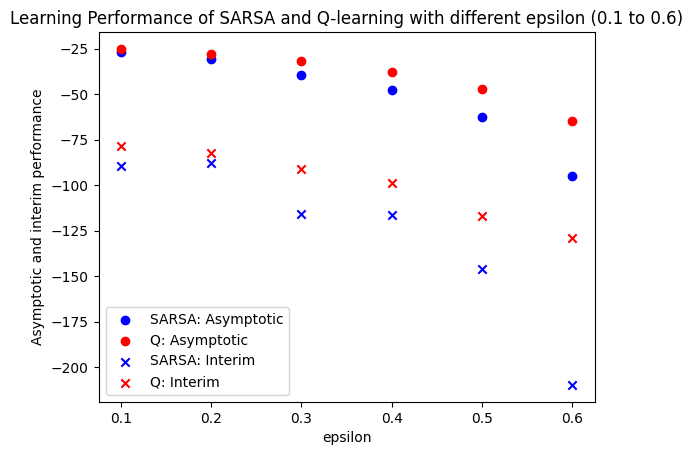

In [26]:
import matplotlib.pyplot as plt

# asymptotic performance and interim performance for different epsilon from 0.1 to 1.0
x_axis = np.arange(0.1, 0.7, 0.1)
plt.scatter(x_axis, asymptotic_performance["SARSA"], color='b')
plt.scatter(x_axis, asymptotic_performance["Q"], color='r')
plt.scatter(x_axis, interim_performance["SARSA"], color='b', marker='x')
plt.scatter(x_axis, interim_performance["Q"], color='r', marker='x')

plt.title("Learning Performance of SARSA and Q-learning with different epsilon (0.1 to 0.6)")
plt.xlabel("epsilon")
plt.ylabel("Asymptotic and interim performance")
plt.xticks(x_axis)
plt.legend(["SARSA: Asymptotic", "Q: Asymptotic", "SARSA: Interim", "Q: Interim"])

plt.show()

From the above, we could easily tell that no matter what algorithm we use and no matter which way we use to measure performance, **the smaller the $\epsilon$ is, the better the learning performance**.

So we simply use $\epsilon = 0.1$ as the $\epsilon$ value for our $\epsilon$-greedy behavior policy.


#### Influence of Initial value of Q

In this section, we compare two ways to initialize Q
- Initialize Q(s,a) = 0, for all s,a
- Initialize Q(s,a) with large values (we take -1000 as large values)
- Initialize Q(s,a) randomly using standard normal distribution N(0,1)



In [27]:
# Windy Grid World
from WindyGridWorld import WindyGridWorld
env = WindyGridWorld()
env.reset()

num_actions = env.action_space.n 
num_states = env.observation_space.n 
num_episodes = 1000
lr = 0.5
gamma = 1

# initialize performance vector for different epsilon and TD methods
interim_performance = {"SARSA": [0] * 3, "Q": [0] * 3}
asymptotic_performance = {"SARSA": [0] * 3, "Q": [0] * 3}

def initialize_Q_zero():
    return {i: [0] * num_actions for i in range(num_states)}

def initialize_Q_large():
    return {i: [-1000] * num_actions for i in range(num_states)}

# Initialize Q(s,a) = np.random.normal() for all non-terminal state
def initialize_Q_random():
    Q = {i: [0] * num_actions for i in range(num_states)}
    for state in Q:
        # if is terminal state
        if state != 37:
            for j in range(num_actions):
                Q[state][j] = np.random.normal()
    return Q

initialize_Q_strategy = [initialize_Q_zero, initialize_Q_large, initialize_Q_random]

for index, initial_Q in enumerate(initialize_Q_strategy):
    
    # SARSA learning
    # reset Q(s,a) before start learning
    Q = initial_Q()
    
    optimal_sarsa_Q, sarsa_optimal_policy, sarsa_info = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)
    #print("\n WindyGridWorld SARSA Optimal policy: \n", sarsa_optimal_policy)
    average_total_rewards_asymptotic = sum(sarsa_info["rewards"])/len(sarsa_info["rewards"])
    average_total_rewards_interim = sum(sarsa_info["rewards"][:100])/len(sarsa_info["rewards"][:100])

    print(f"Asymptotic performance of SARSA learning with strategy {index+1} is: " , average_total_rewards_asymptotic)
    print(f"Interim performance of SARSA learning with strategy {index+1} is: " , average_total_rewards_interim)
    asymptotic_performance["SARSA"][index] = average_total_rewards_asymptotic
    interim_performance["SARSA"][index] = average_total_rewards_interim

    # Q learning
    # reset Q(s,a) before start learning
    Q = initial_Q()
    
    optimal_Q, q_optimal_policy, q_info = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)
    #print("\n WindyGridWorld Q-Learning Optimal policy: \n", q_optimal_policy)
    average_total_rewards_asymptotic = sum(q_info["rewards"])/len(q_info["rewards"])
    average_total_rewards_interim = sum(q_info["rewards"][:100])/len(q_info["rewards"][:100])

    print(f"Asymptotic performance of Q learning with strategy {index+1} is: " , average_total_rewards_asymptotic)
    print(f"Interim performance of Q learning with strategy {index+1} is: " , average_total_rewards_interim)
    asymptotic_performance["Q"][index] = average_total_rewards_asymptotic
    interim_performance["Q"][index] = average_total_rewards_interim


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 464.21it/s]


Asymptotic performance of SARSA learning with strategy 1 is:  -90.963
Interim performance of SARSA learning with strategy 1 is:  -179.3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 819.37it/s]


Asymptotic performance of Q learning with strategy 1 is:  -64.618
Interim performance of Q learning with strategy 1 is:  -128.35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 541.01it/s]


Asymptotic performance of SARSA learning with strategy 2 is:  -91.398
Interim performance of SARSA learning with strategy 2 is:  -178.68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 744.88it/s]


Asymptotic performance of Q learning with strategy 2 is:  -66.37
Interim performance of Q learning with strategy 2 is:  -133.45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.88it/s]


Asymptotic performance of SARSA learning with strategy 3 is:  -96.312
Interim performance of SARSA learning with strategy 3 is:  -198.36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 708.72it/s]

Asymptotic performance of Q learning with strategy 3 is:  -63.76
Interim performance of Q learning with strategy 3 is:  -138.3


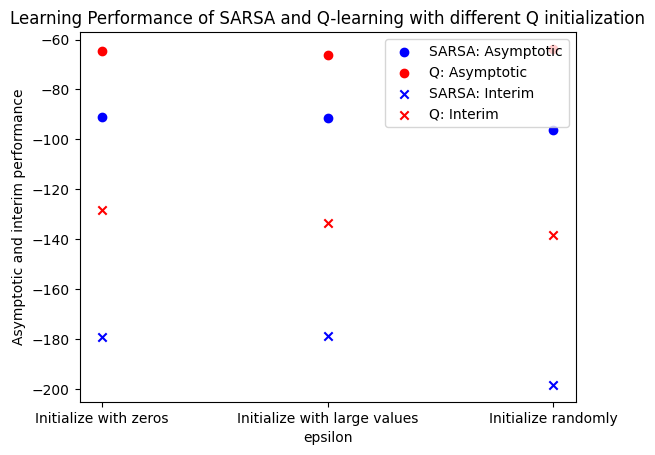

In [28]:
import matplotlib.pyplot as plt

# asymptotic performance and interim performance for different Q initialization
x_axis = ["Initialize with zeros", "Initialize with large values", "Initialize randomly"]
plt.scatter(x_axis, asymptotic_performance["SARSA"], color='b')
plt.scatter(x_axis, asymptotic_performance["Q"], color='r')
plt.scatter(x_axis, interim_performance["SARSA"], color='b', marker='x')
plt.scatter(x_axis, interim_performance["Q"], color='r', marker='x')

plt.title("Learning Performance of SARSA and Q-learning with different Q initialization")
plt.xlabel("epsilon")
plt.ylabel("Asymptotic and interim performance")
plt.xticks(x_axis)
plt.legend(["SARSA: Asymptotic", "Q: Asymptotic", "SARSA: Interim", "Q: Interim"])

From the above, we could see there is no significant difference among these three initialization choice in Windy Grid World.

So we simply choose to use initialize with zero.

# Task 2: Analysis (Comparison of Q-learning and SARSA learning algorithms)

1. Comment on the number of episodes required to converge to the optimal policy for both environments. 
       
2. Discuss the differences in the reward graphs.  

3. Calculate the average return across the episodes for each environment. It gives a measure of the performance of the algorithm while learning (i.e., online performance).  

4. Calculate the return after convergence. It gives you a measure of the performance after the learning is completed (i.e., offline performance). 

5. Briefly summarize your results.
 
 It is advisable to rerun the algorithm a few times to get a clearer understanding of the algorithms.

In [40]:
############################################################################################################
############################################## Cliff Walking ###############################################
############################################################################################################

env = gym.make('CliffWalking-v0') # Create the environment #render_mode="human"  human, ansi, 
env.reset() # reset environment to a new, random state

num_actions = env.action_space.n 
num_states = env.observation_space.n 
num_episodes = 500
lr = 0.5
epsilon = 0.1 
gamma = 1

# SARSA Learning
# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}
_, sarsa_optimal_policy_cliff_walking, sarsa_info_cliff_walking = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)

# Q Learning
# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}
_, q_optimal_policy_cliff_walking, q_info_cliff_walking = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)


############################################################################################################
############################################## Windy Grid World ############################################
############################################################################################################

from WindyGridWorld import WindyGridWorld
env = WindyGridWorld()
env.reset()

num_actions = env.action_space.n 
num_states = env.observation_space.n 
num_episodes = 1000
lr = 0.5
epsilon = 0.1 
gamma = 1

# SARSA Learning
# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}
_, sarsa_optimal_policy_windy_grid_world, sarsa_info_windy_grid_world = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)

# Q-learning
# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}
_, q_optimal_policy_windy_grid_world, q_info_windy_grid_world = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1930.22it/s]


### 1. Number of episodes required to converge to the optimal policy

To calculate the time when the algorithm has converged to the optimal policy for both environments, we use the first time the agent gets a total reward which has less than 20% error when compared to the best rewards throughout the whole learning process as the time of convergence.

In other words, if $|\frac{\mbox{total reward}_n - \mbox{best total reward}}  {\mbox{best total reward}}| < 0.2$, then we say the episode n is the time when the algorithm converges.


In [41]:
# we treat the first episode when the agent gets a total rewards which has < 10% discrepancy when compared to 
# the best total reward throughout the whole learning phase as the time the algorithm converges
def find_converge(rewards_list):
    best_utility = np.max(rewards_list)
    for index, utility in enumerate(rewards_list):
        error = abs(utility - best_utility) / abs(best_utility)
        if error < 0.2:
            return index
        
def plot_reward_graph(sarsa_reward, q_reward, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(sarsa_reward)
    ax[0].set_title("Episode reward over time (SARSA learning)")
    ax[0].set(xlabel="Episode reward over time", ylabel="Reward")
    
    ax[1].plot(q_reward)
    ax[1].set_title("Episode reward over time (Q-learning)")
    ax[1].set(xlabel="Episode reward over time", ylabel="Reward")

    fig.suptitle(title)

    plt.show()
    

#### Cliff Walking Environment

The number of episodes required to converge for SARSA learning in Cliff Walking is:  58
The number of episodes required to converge for Q-learning in Cliff Walking is:  64


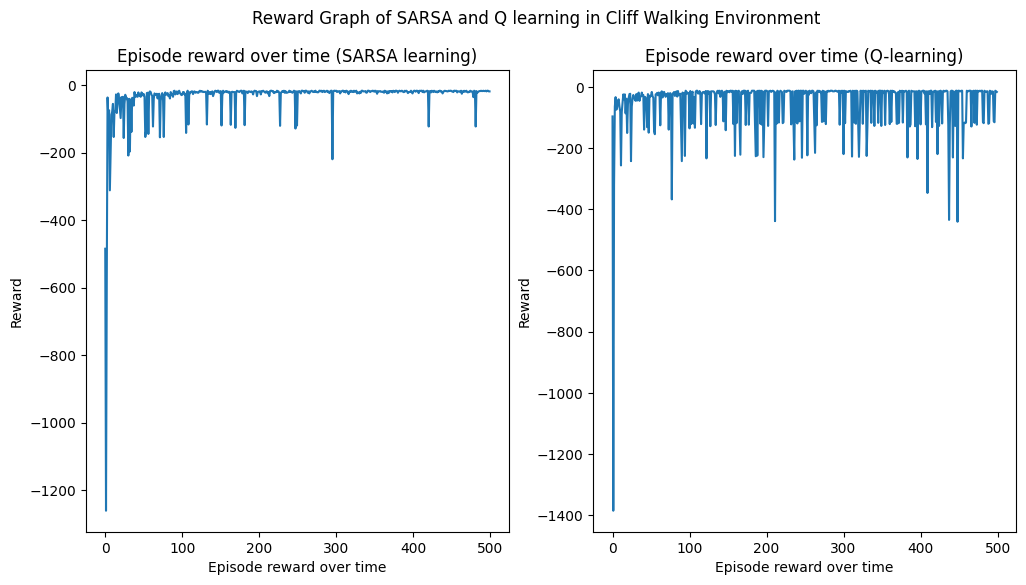

In [42]:
print("The number of episodes required to converge for SARSA learning in Cliff Walking is: ", find_converge(sarsa_info_cliff_walking["rewards"]))
print("The number of episodes required to converge for Q-learning in Cliff Walking is: ", find_converge(q_info_cliff_walking["rewards"]))
plot_reward_graph(sarsa_info_cliff_walking["rewards"], q_info_cliff_walking["rewards"], "Reward Graph of SARSA and Q learning in Cliff Walking Environment")

If we use this method to judge convergence, number of episodes needed to converge for both algorithms in Cliff Walking Environment are generally around 50-100 episodes. Sometimes SARSA learning converges with less episodes, sometimes Q-learning converges with less episodes. Due to stochastic property of behavior policy, the total rewards gotten by the agent in each episode even after convergence are not stable. So we can only have a rough estimation of the time when the algorithm converges which is not accurate and reliable.

#### Windy Grid World

The number of episodes required to converge for SARSA learning in Windy Grid World is:  73
The number of episodes required to converge for Q-learning in Windy Grid World is:  56


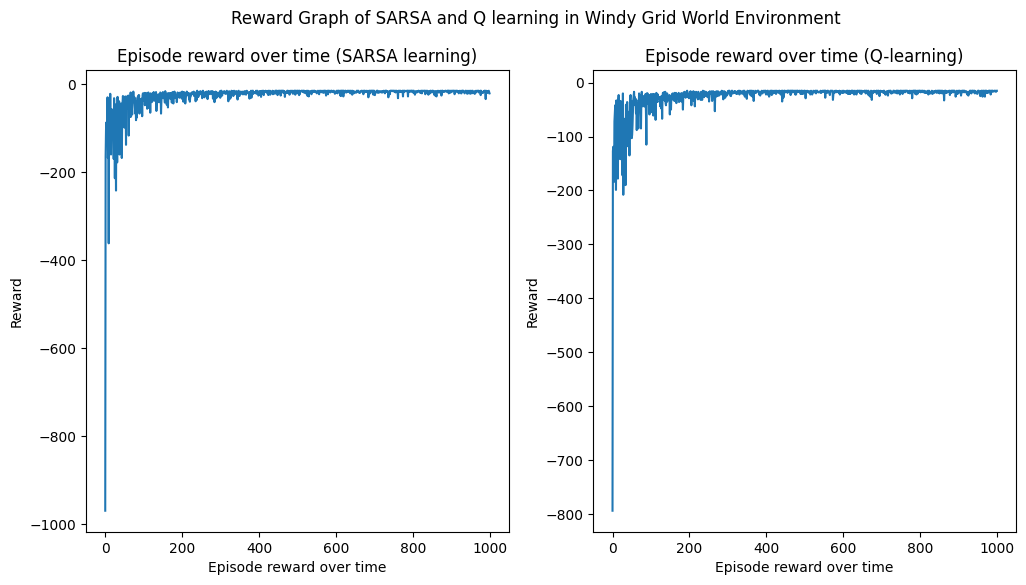

In [43]:
print("The number of episodes required to converge for SARSA learning in Windy Grid World is: ", find_converge(sarsa_info_windy_grid_world["rewards"]))
print("The number of episodes required to converge for Q-learning in Windy Grid World is: ", find_converge(q_info_windy_grid_world["rewards"]))
plot_reward_graph(sarsa_info_windy_grid_world["rewards"], q_info_windy_grid_world["rewards"], "Reward Graph of SARSA and Q learning in Windy Grid World Environment")

If we use this method to judge convergence, number of episodes needed to converge for both algorithms in Windy Grid World Environment are generally around 100-200 episodes. Sometimes SARSA learning converges with less episodes, sometimes Q-learning converges with less episodes. Again, due to stochastic property of behavior policy, the total rewards gotten by the agent in each episode even after convergence are not stable. So we can only have a rough estimation of the time when the algorithm converges which is not accurate and reliable.

### 2. Discussion on the differences in the reward graphs

From the reward graphs above, it is obvious that **in Cliff Walking Environment, the episode reward over time are much more stable with SARSA learning whereas the episode reward over time with Q-learning are much more rugged.** In Cliff Walking Environment, Q-learning often drops to very bad total reward in some episodes even after learning for hundreds of episodes. In contrast, after learning for around 100 episodes, SARSA learning seldom drop to very bad total reward. As we will see in the next two section, this is because the SARSA learning tries to **behave safer** in Cliff Walking Environment, whereas Q-learning tries to **behave optimal** in Cliff Walking Environment which makes the agent frequently bumps into the cliff and thus has a bad online performance. 

In Windy Grid World Environment, the difference between SARSA and Q-learning in reward graph is not so obvious. The reward  graph of SARSA and Q learning are similar to each other.

### 3. Online Performance

#### Cliff Walking environment

In [44]:
print("Average total rewards across episodes of SARSA learning in Cliff Walking is: " ,sum(sarsa_info_cliff_walking["rewards"])/num_episodes)
print("Average total rewards across episodes of Q learning in Cliff Walking is: " , sum(q_info_cliff_walking["rewards"])/num_episodes)

Average total rewards across episodes of SARSA learning in Cliff Walking is:  -17.049
Average total rewards across episodes of Q learning in Cliff Walking is:  -27.172


In Cliff Walking environment, the average total rewards of SARSA learning across episodes is significant higher than that of Q-leanring. So, **the online performance of SARSA leanring is significant better than online performance of Q-learning in Cliff Walking Environment**. 

#### Windy Grid World Environment

In [46]:
print("Average total rewards across episodes of SARSA learning in Windy Grid World is: " , sum(sarsa_info_windy_grid_world["rewards"])/num_episodes)
print("Average total rewards across episodes of Q-learning in Windy Grid World is: " , sum(q_info_windy_grid_world["rewards"])/num_episodes)

Average total rewards across episodes of SARSA learning in Windy Grid World is:  -26.15
Average total rewards across episodes of Q-learning in Windy Grid World is:  -24.947


In Windy Grid World Environment, the average total rewards across episodes of SARSA learning and Q learning are similar to each other. Q-learning has a small advantage over SARSA learning in average total rewards across episodes in this environment. So **the online performance of SARSA learning and Q learning are similar in Windy Grid World Environment**.

#### Conclusion

In conclusion:
- In Cliff Walking environment, SARSA learning's online performance is better than that of Q-learning
- In Windy Grid World environment, the online performance of SARSA and Q learning are similar

**Generally, SARSA learning's online performance is better than Q learning's online performance.**

### 4. Offline Performance

We compare the offline performance of SARSA and Q-learning by calculating the total rewards when the agent acts in the both environments under the policy found by SARSA and Q-learning after convergence.



In [47]:
# evaluate policy found by SARSA or Q learning by executing them in the env
def policy_evaluate(policy, env):
    total_reward = 0
    state = env.reset()
    is_done = False
    while not is_done:
        action = policy[state]
        # take action in state
        next_state, reward, is_done, _ = env.step(action)
        state = next_state
        total_reward += reward
    return total_reward

#### Cliff Walking Environment

In [48]:
env = gym.make('CliffWalking-v0') # Create the environment #render_mode="human"  human, ansi,
env.reset()
num_actions = env.action_space.n 
num_states = env.observation_space.n 
num_episodes = 500

# SARSA learning
print("\n Cliff Walking Environment SARSA Optimal policy: \n", sarsa_optimal_policy_cliff_walking)
print()
print(f"Total rewards of SARSA learning optimal policy after convergence is: {policy_evaluate(sarsa_optimal_policy_cliff_walking, env)}")

# Q-learning
print("\n Cliff Walking Environment Q-Learning Optimal policy: \n", q_optimal_policy_cliff_walking)
print()
print(f"Total rewards of Q-learning optimal policy after convergence is: {policy_evaluate(q_optimal_policy_cliff_walking, env)}")



 Cliff Walking Environment SARSA Optimal policy: 
 {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 0, 13: 0, 14: 0, 15: 3, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 21: 0, 22: 1, 23: 2, 24: 0, 25: 0, 26: 0, 27: 1, 28: 3, 29: 3, 30: 0, 31: 0, 32: 0, 33: 0, 34: 1, 35: 2, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}

Total rewards of SARSA learning optimal policy after convergence is: -17

 Cliff Walking Environment Q-Learning Optimal policy: 
 {0: 2, 1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 2, 19: 1, 20: 1, 21: 1, 22: 2, 23: 2, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 2, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}

Total rewards of Q-learning optimal policy after convergence is: -13


Firstly, we compare the two algorithms in Cliff Walking Environment. From the executing results below, we found that the policy found by SARSA learning will let the agent choose a longer path with 17 steps whereas the policy found by Q-learning will only let the agent move in a shorter path with 13 steps. In other words, **the policy found by SARSA learning is suboptimal, whereas the policy found by Q-learning is optimal**.

Actually, if we further inspect the policy returned by SARSA learning after convergence (see below picture), we will find that SARSA learning tries to move away from the cliff as much as possible which leads to a suboptimal path in Cliff Walking environment. In other words, SARSA leanring tries to behave **safer**.

On the other hand, if we inspect the policy returned by Q learning after convergence (see below picture), we will find that the path Q learning found is actually optimal in Cliff Walking environment.

In [49]:
def dispatch(action_num):
    dispatch_dict = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    return dispatch_dict[action_num]     

def pretty_print(policy_list):
    r = len(policy_list)
    c = len(policy_list[0])
    for i in range(r):
        print(" ".join(policy_list[i]))

# rearrange the sarsa_optimal_policy into a 2D array and print out
policy_list = [-1] * num_states
for k,v in sarsa_optimal_policy_cliff_walking.items():
    policy_list[k] = dispatch(v)
policy_list = np.reshape(policy_list,(4,12))
print("Policy returned by SARSA learning is:")
pretty_print(policy_list)

# rearrange the sarsa_optimal_policy into a 2D array and print out
policy_list = [-1] * num_states
for k,v in q_optimal_policy_cliff_walking.items():
    policy_list[k] = dispatch(v)
policy_list = np.reshape(policy_list,(4,12))
print("Policy returned by Q learning is:")
pretty_print(policy_list)

Policy returned by SARSA learning is:
→ → → → → → → → → → → ↓
↑ ↑ ↑ ← ↑ ↑ → ↑ ↑ ↑ → ↓
↑ ↑ ↑ → ← ← ↑ ↑ ↑ ↑ → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑
Policy returned by Q learning is:
↓ ↑ → → → ↓ → → → → → ↓
→ → → → → → ↓ → → → ↓ ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑


#### Windy Grid World Environment

In [50]:
# Windy Grid World
from WindyGridWorld import WindyGridWorld
env = WindyGridWorld()
env.reset()

num_actions = env.action_space.n 
num_states = env.observation_space.n 
num_episodes = 1000

# SARSA learning
print("\n WindyGridWorld SARSA Optimal policy: \n", sarsa_optimal_policy_windy_grid_world)
print()
print(f"Total rewards of SARSA learning optimal policy after convergence is: {policy_evaluate(sarsa_optimal_policy_windy_grid_world, env)}")

# Q-learning
print("\n WindyGridWorld Q-Learning Optimal policy: \n", q_optimal_policy_windy_grid_world)
print()
print(f"Total rewards of Q-learning optimal policy after convergence is: {policy_evaluate(q_optimal_policy_windy_grid_world, env)}")



 WindyGridWorld SARSA Optimal policy: 
 {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 2, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 0, 28: 1, 29: 2, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1, 39: 2, 40: 1, 41: 2, 42: 1, 43: 1, 44: 2, 45: 2, 46: 0, 47: 2, 48: 3, 49: 3, 50: 0, 51: 2, 52: 1, 53: 1, 54: 1, 55: 0, 56: 0, 57: 2, 58: 3, 59: 0, 60: 2, 61: 2, 62: 3, 63: 1, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 3}

Total rewards of SARSA learning optimal policy after convergence is: -15

 WindyGridWorld Q-Learning Optimal policy: 
 {0: 0, 1: 3, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 3, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 2, 20: 0, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 3, 28: 1, 29: 2, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1, 39: 2, 40: 2, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 2, 48: 3, 49: 3, 50: 3, 51: 1, 52:

In [52]:
# rearrange the sarsa_optimal_policy into a 2D array and print out
policy_list = [-1] * num_states
for k,v in sarsa_optimal_policy_windy_grid_world.items():
    policy_list[k] = dispatch(v)
policy_list = np.reshape(policy_list,(7,10))
print("Policy returned by SARSA learning is:")
pretty_print(policy_list)

# rearrange the sarsa_optimal_policy into a 2D array and print out
policy_list = [-1] * num_states
for k,v in q_optimal_policy_windy_grid_world.items():
    policy_list[k] = dispatch(v)
policy_list = np.reshape(policy_list,(7,10))
print("Policy returned by Q learning is:")
pretty_print(policy_list)

Policy returned by SARSA learning is:
→ ↑ → → → → → → → ↓
↑ → ↑ → → → → → → ↓
→ → → → → → → ↑ → ↓
→ → → → → → → ↑ → ↓
→ ↓ → → ↓ ↓ ↑ ↓ ← ←
↑ ↓ → → → ↑ ↑ ↓ ← ↑
↓ ↓ ← → ↑ ↑ ↑ ↑ ↑ ←
Policy returned by Q learning is:
↑ ← → → → → → → → ↓
← → → → → → → → → ↓
↑ → → → → → → ← → ↓
→ → → → → → → ↑ → ↓
↓ → → → → → ↑ ↓ ← ←
← → → → → ↑ ↑ ↓ ← ↓
← → → → ↑ ↑ ↑ ↑ ↑ →


In this Windy Grid World Environment, **both SARSA and Q learning found the optimal policy of this environment**. Both of the policies found by both algorithms will only require the agent to take only 15 steps before reaching the goal state.

By inspecting both policies found by SARSA and Q learning, we could also easily tell that the policies they found are optimal.
(Although they differ in some states which are not reachable if the agent acts under these policies since the actions in Windy Grid World Environment is actually deterministic).


In conclusion: 
- Q-learning can find optimal policy in Cliff Walking environment while SARSA learning only comes up with a suboptimal one.
- Both Q-learning and SARSA learning can find optimal policy in WindyGrid World Environment

Generally we could conclude that **the offline performance of Q-learning is better than the offline performance of SARSA learning.**

### 5. Summary

In the Cliff Walking Environment, the number of episodes needed to converge for both algorithms are around 50-100 episodes. Sometimes SARSA learning requires less episodes to converge and sometimes Q learning requires less episodes to converge.

- SARSA learning has a significant better online performance than Q-learning
   - Q-learning often bumps into cliff during the learning process even when having learnt for hundreds of episodes
   - SARSA learning seldom bumps into cliff during the learning process after 100 episodes
- Q-learning's offline performance is better than SARSA learning. To be more specific:
   - the policy found by SARSA learning is suboptimal
   - the policy found by Q-learning is optimal
   
In other words, SARSA behaves safer while Q-learning behaves optimal in Cliff Walking Environment


In the Windy Grid World Environment, the number of episodes needed to converge for both algorithms are around 100-200 episodes. Sometimes SARSA learning requires less episodes to converge and sometimes Q learning requires less episodes to converge.

- SARSA and Q learning has similar online performance and similar rewards graph
- SARSA and Q learning has similar offline performance. The policies found by SARSA and Q learning are both optimal

In other words, SARSA and Q learning has similar behavior in Windy Grid World Environment.

In conclusion:

- **SARSA generally has a better online performance** while **Q-learning generally has a better offline performance**. Or rather, **SARSA learning is more suitable for online learning** while **Q-learning is more suitable for offline learning**.
- **SARSA learning behaves safer** while **Q-learning behaves optimal in Cliff Walking Environment**. **SARSA learning and Q-learning behaves similar (both optimal) in Windy Grid World Environment**.